In [7]:
from __future__ import annotations
import numpy as np, pandas as pd
import fastf1 as ff1
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.collections import LineCollection
from dataclasses import dataclass
from pathlib import Path

core           INFO 	Loading data for British Grand Prix - Qualifying [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '18'
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['63', '44', '4', '1', '81', '27', '55', '18', '23', '14', '16', '2', '22', '24', '3', '77', '20', '31', '11', '10']
/var/folders/sw/wp_nytcd1d705bjyy

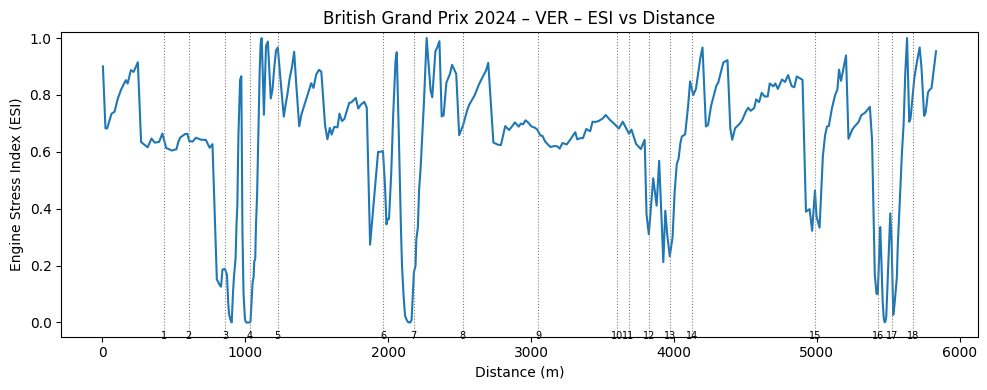

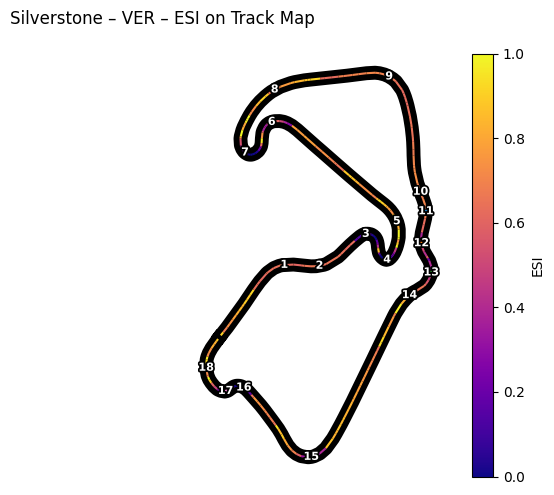


Top-5 stress corners (mean ESI):
 Corner  Distance_m  ESI_mean  ESI_p95  Time_s
     5 1227.141721  0.905307 0.965023    0.92
    18 5675.839138  0.820198 0.910278    1.20
    14 4125.836967  0.803135 0.843619    1.12
    10 3604.978324  0.689278 0.700081    0.72
     8 2521.612691  0.678074 0.691635    0.64

Top-5 stress straights (mean ESI):
     Segment     Start_m       End_m  ESI_mean  Time_s
Straight_19 5705.839138 5804.488056  0.829648    1.52
 Straight_8 2208.607483 2491.612691  0.799178    4.72
Straight_15 4155.836967 4959.114737  0.781037    9.48
 Straight_1   30.000000  401.136413  0.746741    4.68
 Straight_6 1257.141721 1936.547115  0.735469    8.60


In [8]:
# --- cache setup
CACHE_DIR = Path("./.fastf1cache")
CACHE_DIR.mkdir(parents=True, exist_ok=True)
ff1.Cache.enable_cache(str(CACHE_DIR))

# ---------- utilities
def robust_minmax(x: pd.Series, q_lo=0.05, q_hi=0.95) -> pd.Series:
    lo, hi = x.quantile(q_lo), x.quantile(q_hi)
    return ((x - lo) / max(1e-6, (hi - lo))).clip(0, 1)

def positive_accel(speed_kph: pd.Series, time: pd.Series) -> pd.Series:
    # Convert speed to m/s, differentiate wrt time (s)
    v = speed_kph.fillna(method="ffill") * (1000/3600)
    dt = time.diff().dt.total_seconds().replace(0, np.nan)
    a = v.diff() / dt
    a = a.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    return a.clip(lower=0.0)

@dataclass
class ESIWeights:
    rpm: float = 0.6
    throttle: float = 0.3
    accel: float = 0.1
    rpm_power: float = 2.0  # non-linear emphasis

def compute_esi_lap(lap, weights: ESIWeights = ESIWeights()) -> pd.DataFrame:
    # Telemetry aligned by time; add distance for per-lap progression
    car = lap.get_car_data().add_distance()   # Speed, RPM, Throttle, Distance, Time
    pos = lap.get_pos_data()                  # X, Y, Time
    # Align pos with car telemetry on Time
    tel = pd.merge_asof(car.sort_values("Time"),
                        pos[["Time", "X", "Y"]].sort_values("Time"),
                        on="Time", direction="nearest")

    # Derived features + robust scaling
    tel["a_pos"] = positive_accel(tel["Speed"], tel["Time"])
    tel["RPM_pct"] = robust_minmax(tel["RPM"])
    tel["THR_pct"] = robust_minmax(tel["Throttle"])
    tel["ACC_pct"] = robust_minmax(tel["a_pos"])

    # ESI
    tel["ESI"] = (weights.rpm * (tel["RPM_pct"] ** weights.rpm_power) +
                  weights.throttle * tel["THR_pct"] +
                  weights.accel * tel["ACC_pct"])

    # Δt for integration
    tel["dt"] = tel["Time"].diff().dt.total_seconds().fillna(0.0)
    tel.loc[tel["dt"] < 0, "dt"] = 0  # safety for any tiny time jitter
    return tel

def aggregate_by_corners(session, tel: pd.DataFrame, window_m: float = 30.0) -> pd.DataFrame:
    ci = session.get_circuit_info()
    corners = ci.corners.copy()  # Number, Letter, Distance, (X, Y, Angle may exist)
    out = []
    lap_len = tel["Distance"].max()

    for _, c in corners.iterrows():
        center = float(c["Distance"])
        # window with wrap-around handling
        lo, hi = center - window_m, center + window_m
        if lo < 0:
            mask = (tel["Distance"] >= (lap_len + lo)) | (tel["Distance"] <= hi)
        elif hi > lap_len:
            mask = (tel["Distance"] >= lo) | (tel["Distance"] <= (hi - lap_len))
        else:
            mask = tel["Distance"].between(lo, hi)

        seg = tel.loc[mask]
        if seg.empty:
            continue
        time_in_window = seg["dt"].sum()
        esi_mean = np.average(seg["ESI"], weights=np.maximum(seg["dt"], 1e-3))
        esi_p95  = seg["ESI"].quantile(0.95)
        out.append({
            "Corner": f"{int(c['Number'])}{c['Letter']}",
            "Distance_m": center,
            "ESI_mean": esi_mean,
            "ESI_p95": esi_p95,
            "Time_s": time_in_window
        })
    return pd.DataFrame(out).sort_values(["ESI_mean", "ESI_p95"], ascending=False)

def segments_straights(session, tel: pd.DataFrame, window_m: float = 30.0) -> pd.DataFrame:
    # Build straight segments between adjacent corners (excluding ±window around corners)
    ci = session.get_circuit_info()
    dists = np.sort(ci.corners["Distance"].values).tolist()
    lap_len = tel["Distance"].max()
    # Include start/finish wrap
    dists = [0.0] + dists + [lap_len]
    segs = []
    for i in range(len(dists)-1):
        start = dists[i] + window_m
        end   = dists[i+1] - window_m
        if end <= start:
            continue
        mask = tel["Distance"].between(start, end)
        seg = tel.loc[mask]
        if seg.empty:
            continue
        time_s = seg["dt"].sum()
        esi_mean = np.average(seg["ESI"], weights=np.maximum(seg["dt"], 1e-3))
        segs.append({"Segment": f"Straight_{i+1}", "Start_m": start, "End_m": end,
                     "ESI_mean": esi_mean, "Time_s": time_s})
    return pd.DataFrame(segs).sort_values("ESI_mean", ascending=False)

# ---------- demo (choose event/driver)
if __name__ == "__main__":
    session = ff1.get_session(2024, "Silverstone", "Q")
    session.load()

    lap = session.laps.pick_drivers("VER").pick_fastest()
    tel = compute_esi_lap(lap)

    # 1) ESI vs distance with corner markers
    circuit_info = session.get_circuit_info()
    vmin, vmax = tel["ESI"].min(), tel["ESI"].max()
    plt.figure(figsize=(10, 4))
    plt.plot(tel["Distance"], tel["ESI"], label=f"{lap['Driver']} ESI")
    for _, c in circuit_info.corners.iterrows():
        plt.axvline(c["Distance"], ls="dotted", lw=0.8, color="grey")
        txt = f"{int(c['Number'])}{c['Letter']}"
        plt.text(c["Distance"], vmin - 0.03*(vmax - vmin), txt,
                 ha="center", va="top", fontsize=7)
    plt.ylim(vmin - 0.05*(vmax - vmin), vmax * 1.02)
    plt.xlabel("Distance (m)")
    plt.ylabel("Engine Stress Index (ESI)")
    plt.title(f"{session.event['EventName']} {session.event.year} – {lap['Driver']} – ESI vs Distance")
    plt.tight_layout()
    plt.show()

    # 2) Track map colored by ESI + corner labels
    points = np.array([tel["X"].values, tel["Y"].values]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap="plasma",
                        norm=plt.Normalize(tel["ESI"].min(), tel["ESI"].max()))
    lc.set_array(tel["ESI"].values)
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.axis("off")
    ax.add_collection(lc)
    ax.plot(tel["X"], tel["Y"], color="black", lw=10, zorder=0)  # background track
    ax.set_aspect("equal", adjustable="box")
    cb = plt.colorbar(lc, ax=ax, fraction=0.046, pad=0.04)
    cb.set_label("ESI")
    fig.suptitle(f"{session.event['Location']} – {lap['Driver']} – ESI on Track Map")

    # --- Corner number labels on the track map ---
    corners_df = circuit_info.corners.copy()

    def corner_xy(row) -> tuple[float, float]:
        # Prefer curated coordinates if available; otherwise, use nearest telemetry point by distance
        if {"X", "Y"}.issubset(corners_df.columns):
            return float(row["X"]), float(row["Y"])
        idx = (tel["Distance"] - float(row["Distance"])).abs().idxmin()
        return float(tel.loc[idx, "X"]), float(tel.loc[idx, "Y"])

    for _, c in corners_df.iterrows():
        label = f"{int(c['Number'])}{c['Letter']}"
        x, y = corner_xy(c)
        # small dot to mark the corner and a legible label with halo
        ax.scatter([x], [y], s=12, zorder=5, linewidths=0.5, edgecolors="black")
        ax.text(
            x, y, label,
            ha="center", va="center", fontsize=8, weight="bold", color="white", zorder=6,
            path_effects=[pe.withStroke(linewidth=2.5, foreground="black")]
        )

    plt.tight_layout()
    plt.show()

    # 3) Tables: top stress corners and straights
    corners_df_out = aggregate_by_corners(session, tel, window_m=30.0).head(5)
    print("\nTop-5 stress corners (mean ESI):\n", corners_df_out.to_string(index=False))

    straights_df = segments_straights(session, tel, window_m=30.0).head(5)
    print("\nTop-5 stress straights (mean ESI):\n", straights_df.to_string(index=False))